# Preguntas

- Cual es el numero de tarea? The doc says proyecto 1

Proyecto 1 - Luis Eduardo Robles Jimenez

# Minería de Texto para Turismo

## Utils

In [103]:
import os
import numpy as np
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.tokenize import TweetTokenizer

In [104]:
class TouristSpot:
    def __init__(self, path):
        self.reviews = pd.read_csv(path)
        self.spotName = path.split('/')[-1][: -4]
        self._cleanUp()
        self.nDashes = 30

    def _cleanUp(self):
        self.reviews.columns = [c.strip() for c in self.reviews.columns]

        if self.reviews.loc[:, 'Edad'].dtypes == object: self.reviews.loc[:, 'Edad'] = [n.strip() for n in self.reviews.loc[:, 'Edad']]
        self.reviews.loc[:, 'Edad'] = self.reviews.loc[:, 'Edad'].replace([np.nan, ''], -1)
        self.reviews.loc[:, 'Edad'] = self.reviews.loc[:, 'Edad'].astype('int32')

        columns = ["Título de la opinión", "Opinión"]
        for col in columns:
            desc = []       
            for o in self.reviews.loc[:, col]:
                if o[0] == '"': o = o[1:]
                if o[-1] == '"': o = o[:-1]
                desc.append(o)
            self.reviews.loc[:, col] = desc

    def wordCloud(self):
        #pip install wordcloud
        pass

    def temporalAnalysis(self):
        self.reviews['newDate'] = ['/'.join(date.split('/')[1:]) for date in self.reviews.loc[:, 'Fecha']]
        dates, grades = [], []
        for groupName, reviewsGroup in self.reviews.groupby('newDate'):
            dates.append(groupName)
            grades.append(np.average(reviewsGroup.loc[:, 'Escala']))
        plt.figure(figsize = (15, 15))
        plt.barh(dates, grades)
        plt.title('Average grade by month')
        
        return
        self.reviews['newDate'] = ['/'.join(date.split('/')[1:]) for date in self.reviews.loc[:, 'Fecha']]
        dates, grades = [], []
        for groupName, reviewsGroup in self.reviews.groupby('newDate'):
            dates.append(groupName)

            grade = [0, 0, 0]
            gra, cou = np.unique(reviewsGroup.loc[:, 'Escala'], return_counts = True)
            for g, c in zip(gra, cou):
                if g < 3: grade[0] += c
                if g == 3: grade[1] += c
                if g > 3: grade[2] += c

        return        
        months = ("Adelie", "Chinstrap", "Gentoo")
        penguin_means = {
            'Bill Depth': (18.35, 18.43, 14.98),
            'Bill Length': (38.79, 48.83, 47.50),
            'Flipper Length': (189.95, 195.82, 217.19),
        }

        x = np.arange(len(months))  # the label locations
        width = 0.25  # the width of the bars
        multiplier = 0

        fig, ax = plt.subplots(layout='constrained')

        for attribute, measurement in penguin_means.items():
            offset = width * multiplier
            rects = ax.bar(x + offset, measurement, width, label=attribute)
            ax.bar_label(rects, padding=3)
            multiplier += 1

        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax.set_ylabel('Length (mm)')
        ax.set_title('Reviews through the pass of time')
        ax.set_xticks(x + width, months)
        #ax.legend(loc='upper left', ncols=3)
        ax.set_ylim(0, 250)

        plt.show()

    def describe(self):
        nRows, nCols = 2, 1
        fig = plt.figure(figsize = (15, 10))
        fig.subplots_adjust(hspace=0.5)

        print(self.nDashes * '-', self.spotName, self.nDashes * '-')

        grades = fig.add_subplot(321)
        avg = np.round(np.average(self.reviews.loc[:, 'Escala']), decimals = 2)
        sd = np.round(np.std(self.reviews.loc[:, 'Escala']), decimals = 2)
        grades.hist(self.reviews.loc[:, 'Escala'])
        grades.set_title(f"Grades (1 worst; 5 best); Average = {avg}; SD = {sd}")

        length = fig.add_subplot(322)
        lenOpinions = [len(TweetTokenizer().tokenize(o)) for o in self.reviews.loc[:, 'Opinión']]
        avg = np.round(np.average(lenOpinions), decimals = 2)
        sd = np.round(np.std(lenOpinions), decimals = 2)
        length.hist(lenOpinions)
        length.set_title(f"Length of opinions (words); Average = {avg}; SD = {sd}")

        ages = fig.add_subplot(323)
        ages.hist(self.reviews.loc[:, 'Edad'], bins = 10)
        ages.set_title(f'Ages distribution')
        
        visitors = fig.add_subplot(324)
        visitors.hist(self.reviews.loc[:, 'Nacional ó Internacional'])
        visitors.set_title('Local or foreigner')
        
        monthNames = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
        popularity = fig.add_subplot(325)
        months = [int(d.split('/')[1]) for d in self.reviews.loc[:, 'Fecha']]
        m, c = np.unique(months, return_counts = True)
        popularity.bar(m, c)
        popularity.set_title('Popularity by month')
        popularity.set_xticks(np.arange(1, len(m) + 1), labels = monthNames)
        
        languages = fig.add_subplot(326)
        m, c = np.unique(self.reviews.loc[:, 'Idioma'], return_counts = True)
        languages.barh(m, c)
        languages.set_title('Language')

        plt.show()

## Actividades

### 1. Preprocesamiento y stats

In [105]:
path = "../../data/guanajuato/"
spots = [TouristSpot(os.path.join(path, d)) for d in os.listdir(path)]

In [106]:
for spot in spots: 
    break
    spot.describe()

In [107]:
text = "Hola como estas, jajajaja, que haces?"
text = "The quick brown fox jumps over the lazy dog dog dog dog dog dog dog dog dog dog dog dog dog dog dog dog dog dog "

wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=3).generate(text)

#plt.figure(figsize=(8,8))
#plt.imshow(wordcloud)
#plt.axis("off")
#plt.tight_layout(pad=0)
#plt.show()


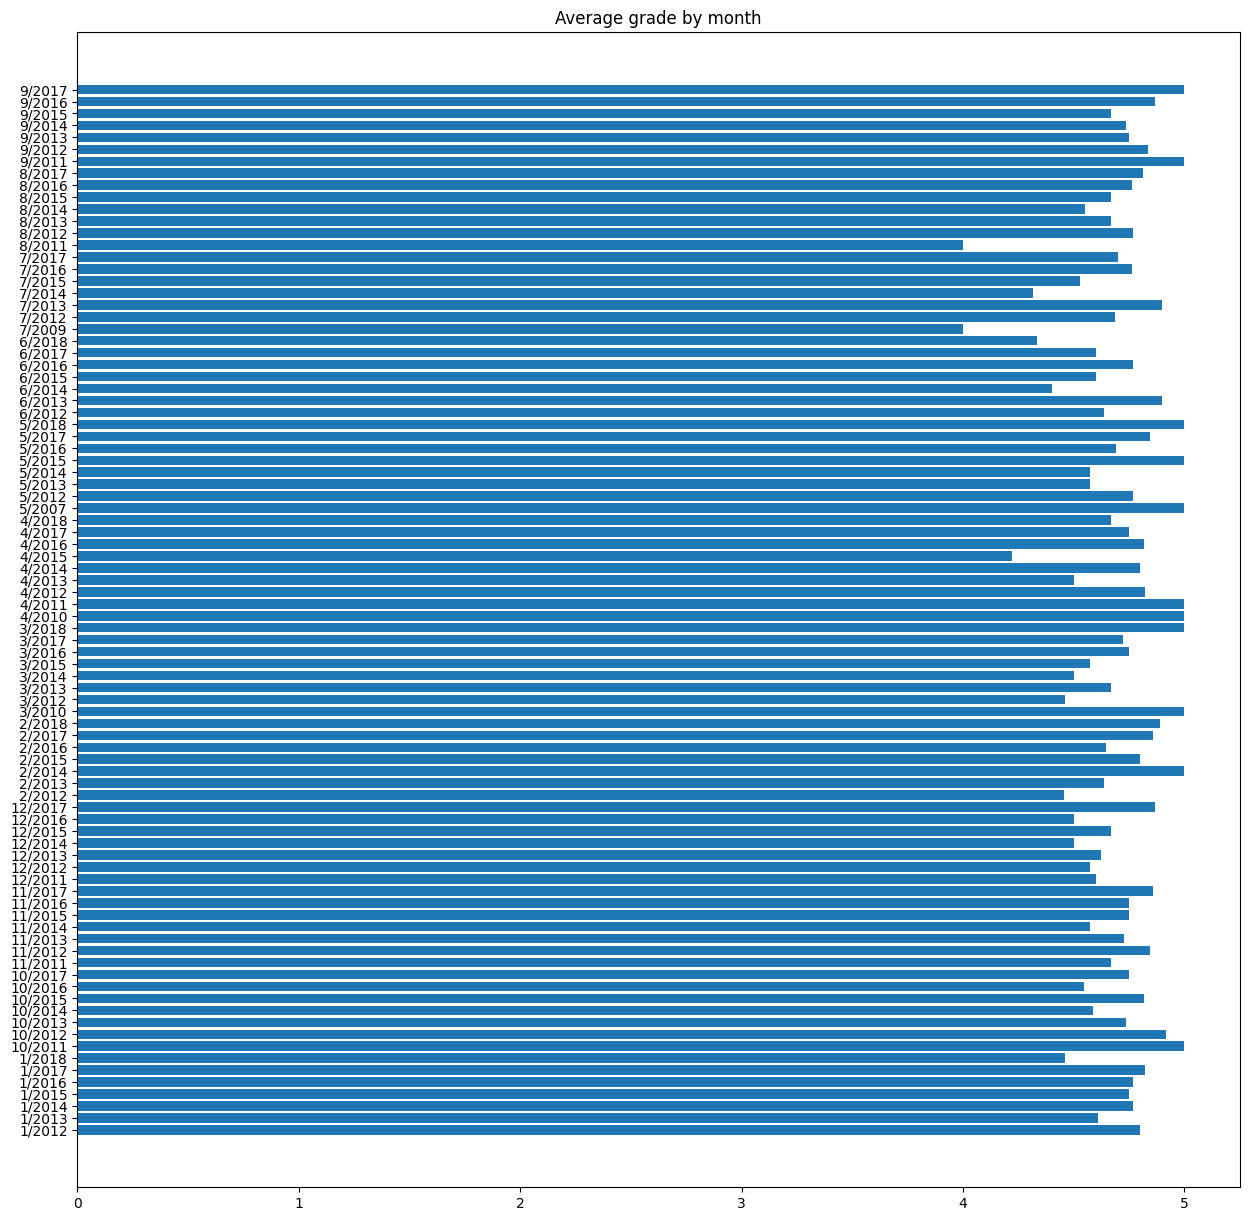

In [108]:
for spot in spots: 
    spot.temporalAnalysis()
    break
    continue